In [9]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import matplotlib.pyplot as plt

In [3]:
r = R.from_matrix([
[0, -1, 0],
[1, 0, 0],
[0, 0, 1]])
r.as_matrix()

array([[ 0., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [6]:
def plot_rotated_axes(ax, r, name=None, offset=(0, 0, 0), scale=1):
    colors = ("#FF6666", "#005533", "#1199EE")  # Colorblind-safe RGB
    loc = np.array([offset, offset])
    for i, (axis, c) in enumerate(zip((ax.xaxis, ax.yaxis, ax.zaxis),
                                      colors)):
        axlabel = axis.axis_name
        axis.set_label_text(axlabel)
        axis.label.set_color(c)
        axis.line.set_color(c)
        axis.set_tick_params(colors=c)
        line = np.zeros((2, 3))
        line[1, i] = scale
        line_rot = r.apply(line)
        line_plot = line_rot + loc
        ax.plot(line_plot[:, 0], line_plot[:, 1], line_plot[:, 2], c)
        text_loc = line[1]*1.2
        text_loc_rot = r.apply(text_loc)
        text_plot = text_loc_rot + loc[0]
        ax.text(*text_plot, axlabel.upper(), color=c,
                va="center", ha="center")
    ax.text(*offset, name, color="k", va="center", ha="center",
            bbox={"fc": "w", "alpha": 0.8, "boxstyle": "circle"})

In [33]:
r0 = R.identity()
r1 = R.from_euler("xyz", [90, -0, 0], degrees=True)  # intrinsic
r2 = R.from_euler("xyz", [-90, -0, 0], degrees=True)  # extrinsic

In [39]:
chi = np.array([np.pi/4, np.pi/2], dtype=np.double)
phi = np.array([0, 0], dtype=np.double)
rotateAngle = np.array([np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi), np.cos(chi)])

print(rotateAngle)

[[7.07106781e-01 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00]
 [7.07106781e-01 6.12323400e-17]]


In [40]:
test1 = np.array([[0, 0, 1], [0, 0, 1]])
a = test1 * rotateAngle.T
print(a)

[[0.00000000e+00 0.00000000e+00 7.07106781e-01]
 [0.00000000e+00 0.00000000e+00 6.12323400e-17]]


In [43]:
r = R.from_rotvec(rotateAngle.T)
test1 = r.apply(test1)

In [45]:
print(np.linalg.norm(test1, axis= 1))

[1. 1.]


In [16]:
rotest = np.array([[np.pi/4, np.pi/2, 0],
                   [np.pi/6, 0., 0.]])

print(rotest.shape)

(2, 3)


In [17]:
test1 = np.array([[0, 0, 1], [0, 0, 1]])
r = R.from_rotvec(rotest)
r.apply(test1)

array([[ 0.87909782, -0.43954891, -0.18434692],
       [ 0.        , -0.5       ,  0.8660254 ]])

In [29]:
vtest = np.array([[1, 1, 3], [2, 1, 1]])
rotest = np.arctan(np.sqrt(vtest[:, 0]**2 + vtest[:, 1]**2)/vtest[:, 2])
print(rotest)
romat = np.zeros((2,3))
romat[0,2] = rotest[0]
romat[1,2] = rotest[1]
print(romat)

[0.44051066 1.15026199]
[[0.         0.         0.44051066]
 [0.         0.         1.15026199]]


In [30]:
r = R.from_rotvec(romat)
r.apply(vtest)

array([[ 0.4781326 ,  1.33093547,  3.        ],
       [-0.09637435,  2.23399015,  1.        ]])

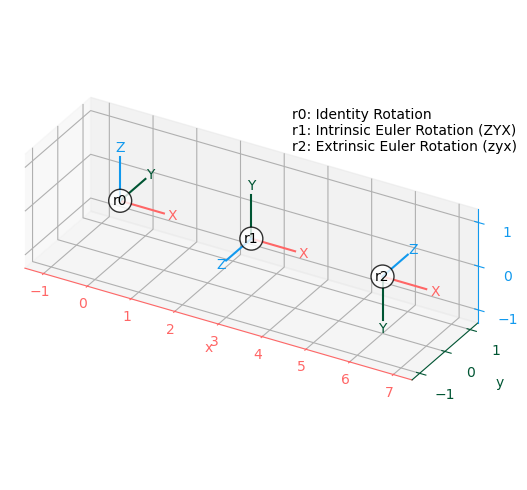

In [34]:
ax = plt.figure().add_subplot(projection="3d", proj_type="ortho")
plot_rotated_axes(ax, r0, name="r0", offset=(0, 0, 0))
plot_rotated_axes(ax, r1, name="r1", offset=(3, 0, 0))
plot_rotated_axes(ax, r2, name="r2", offset=(6, 0, 0))
_ = ax.annotate(
    "r0: Identity Rotation\n"
    "r1: Intrinsic Euler Rotation (ZYX)\n"
    "r2: Extrinsic Euler Rotation (zyx)",
    xy=(0.6, 0.7), xycoords="axes fraction", ha="left"
)
ax.set(xlim=(-1.25, 7.25), ylim=(-1.25, 1.25), zlim=(-1.25, 1.25))
ax.set(xticks=range(-1, 8), yticks=[-1, 0, 1], zticks=[-1, 0, 1])
ax.set_aspect("equal", adjustable="box")
ax.figure.set_size_inches(6, 5)
plt.tight_layout()

In [217]:
def rotate_matrix(phi, theta):
    phi_array = np.expand_dims(phi, axis=(0, 1))
    theta_array = np.expand_dims(theta, axis=(0, 1))
    cos_phi = np.cos(phi_array)
    sin_phi = np.sin(phi_array)
    cos_theta = np.cos(theta_array)
    sin_theta = np.sin(theta_array)
    matrix_i = np.concatenate((cos_theta*cos_phi, cos_theta*sin_phi, -sin_theta), axis=1) # cos theta *cos phi, 
    matrix_j = np.concatenate((matrix_i, np.concatenate((-sin_phi, cos_phi, np.zeros_like(phi_array)), axis=1)), axis=0)
    matrix = np.concatenate((matrix_j, np.concatenate((sin_theta*cos_phi, sin_theta*sin_phi, cos_theta), axis=1)), axis=0)

    return matrix.T

def newVel_gpu(v, vMag, chi, phi):

    vMagnew = vMag
    theta0 = np.arccos(v[:, 2]/vMag)
    phi0= np.arctan(v[:, 0]/v[:, 1])
    # chi = np.arccos(1-2*r/(1+8*(energy/27.21)*(1-r)))
    # phi = 2*np.pi*np.random.rand()
    m1m2 = rotate_matrix(phi0, theta0)
    rotateAngle = np.array([np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi), np.cos(chi)])
    dot_products = np.einsum('...ij,...i->...j', m1m2, rotateAngle.T)

    newVel = dot_products * vMagnew[:, np.newaxis]

    return newVel

In [177]:
def newVel_gpu_sci(v, vMag, chi, phi):

    vMagnew = vMag
    theta0 = np.arccos(v[:, 2]/vMag)
    phi0= np.arctan(v[:, 0]/v[:, 1])
    # chi = np.arccos(1-2*r/(1+8*(energy/27.21)*(1-r)))
    # phi = 2*np.pi*np.random.rand()
    m1m2 = rotate_matrix(phi0, theta0)
    print(np.linalg.det(m1m2))
    r = R.from_matrix(m1m2)
    matrix = r.as_matrix()
    print(np.linalg.det(matrix))
    # v = r.apply(v)
    rotateAngle = np.array([np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi), np.cos(chi)])
    
    dot_products = np.einsum('...ij,...i->...j', m1m2, rotateAngle.T)
    print(np.linalg.det(dot_products))
    r = R.from_matrix(dot_products)
    matrix = r.as_matrix()
    print(np.linalg.det(matrix))
    v = r.apply(v)
    newVel = v

    return newVel

In [178]:
pt = np.array([[np.pi/4, np.pi/2],
                [np.pi/6, 0.]])

In [179]:
rotate_matrix(pt[0], pt[1])

array([[[ 6.12372436e-01, -7.07106781e-01,  3.53553391e-01],
        [ 6.12372436e-01,  7.07106781e-01,  3.53553391e-01],
        [-5.00000000e-01,  0.00000000e+00,  8.66025404e-01]],

       [[ 6.12323400e-17, -1.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00,  6.12323400e-17,  0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]])

In [180]:
rotate_matrix(-pt[0], -pt[1])

array([[[ 6.12372436e-01,  7.07106781e-01, -3.53553391e-01],
        [-6.12372436e-01,  7.07106781e-01,  3.53553391e-01],
        [ 5.00000000e-01,  0.00000000e+00,  8.66025404e-01]],

       [[ 6.12323400e-17,  1.00000000e+00, -0.00000000e+00],
        [-1.00000000e+00,  6.12323400e-17,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]])

In [ ]:
def newVel_gpu_2(v, vMag, chi, phi):

    vMagnew = vMag
    theta0 = np.arccos(v[:, 2]/vMag)
    phi0= np.arctan(v[:, 0]/v[:, 1])
    # chi = np.arccos(1-2*r/(1+8*(energy/27.21)*(1-r)))
    # phi = 2*np.pi*np.random.rand()
    m1m2 = rotate_matrix(phi0, theta0)
    rotateAngle = np.array([np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi), np.cos(chi)])
    dot_products = np.einsum('...ij,...i->...j', m1m2, rotateAngle.T)

    newVel = dot_products * vMagnew[:, np.newaxis]

    return newVel

In [181]:
vtest = np.array([[0, 1e-11, 1], [0, 1e-11, 1]])
chi = np.array([np.pi/3, np.pi/6])
phi = np.array([np.pi/3, np.pi/6])
ttessci = newVel_gpu_sci(vtest, np.linalg.norm(vtest, axis=1), chi, phi)
ttestsm = newVel_gpu(vtest, np.linalg.norm(vtest, axis=1), chi, phi)
np.allclose(ttessci, ttestsm)
print(ttessci)
print(ttestsm)

[1. 1.]
[1. 1.]


LinAlgError: Last 2 dimensions of the array must be square

In [ ]:
def newVel_gpu(v, vMag, chi, phi):

    vMagnew = vMag
    theta0 = np.arccos(v[:, 2]/vMag)
    phi0= np.arctan(v[:, 0]/v[:, 1])
    # chi = np.arccos(1-2*r/(1+8*(energy/27.21)*(1-r)))
    # phi = 2*np.pi*np.random.rand()
    m1m2 = rotate_matrix(phi0, theta0)
    print(m1m2)
    rotateAngle = np.array([np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi), np.cos(chi)])
    dot_products = np.einsum('...ij,...i->...j', m1m2, rotateAngle.T)

    newVel = dot_products * vMagnew[:, np.newaxis]

    return newVel

In [197]:
def newVel(v, vMag, chi, phi):

    theta0 = np.arccos(v[2]/vMag)
    # print("---theta")
    # print(theta0)
    phi0= np.arctan(v[1]/v[0])
    # print("---phi0")
    # print(phi0
    m1 = R.from_rotvec(phi0 * np.array([0, 0, 1])).as_matrix()
    # print("---m1")
    # print(m1)
    m2 = R.from_rotvec(theta0 * np.array([0, 1, 0])).as_matrix()
    # print("---m2")
    # print(m2)
    m1m2 = np.dot(m1, m2)
    # print("---m1m2")
    # print(m1m2)
    rotateAngle = np.array([np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi), np.cos(chi)])
    # print("---rotate")
    vNew = np.dot(m1m2, rotateAngle)*vMag

    return vNew

In [245]:
def newVel(v, vMag, chi, phi):

    theta0 = np.arccos(v[:,2]/vMag)
    # print("---theta")
    # print(theta0)
    phi0= np.arctan(v[:,0]/v[:,1])
    # print("---phi0")
    # print(phi0
    phiM = np.zeros((phi0.shape[0], 3))
    phiM[:,2]  = phi0
    m1 = R.from_rotvec(phiM).as_matrix()
    tM = np.zeros((theta0.shape[0], 3))
    tM[:,1]  = theta0
    m2 = R.from_rotvec(tM).as_matrix()
    # print("---m2")
    # print(m2)
    m1m2 = np.matmul(m1, m2)
    rotateAngle = np.array([np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi), np.cos(chi)])
    # print("---rotate")
    dot_products = np.einsum('...ij,...i->...j', m1m2, rotateAngle.T)
    newVel = dot_products * vMag[:, np.newaxis]

    return newVel

In [210]:
def newVel(v, vMag, chi, phi):

    theta0 = np.arccos(v[2]/vMag)
    print("---theta")
    print(theta0)
    phi0= np.arctan(v[0]/v[1])
    print("---phi0")
    print(phi0)
    m1 = R.from_rotvec(phi0 * np.array([0, 0, 1])).as_matrix()
    # print("---m1")
    # print(m1)
    m2 = R.from_rotvec(theta0 * np.array([0, 1, 0])).as_matrix()
    # print("---m2")
    # print(m2)
    m1m2 = np.dot(m1, m2)
    # print("---m1m2")
    # print(m1m2)
    rotateAngle = np.array([np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi), np.cos(chi)])
    # print("---rotate")
    vNew = np.dot(m1m2, rotateAngle)*vMag

    return vNew.T

In [411]:
def rotate_matrix(phi, theta):
    phi_array = np.expand_dims(phi, axis=(0, 1))
    theta_array = np.expand_dims(theta, axis=(0, 1))
    cos_phi = np.cos(phi_array)
    sin_phi = np.sin(phi_array)
    cos_theta = np.cos(theta_array)
    sin_theta = np.sin(theta_array)
    matrix_i = np.concatenate((cos_theta*cos_phi, cos_theta*sin_phi, -sin_theta), axis=1) # cos theta *cos phi, 
    matrix_j = np.concatenate((matrix_i, np.concatenate((-sin_phi, cos_phi, np.zeros_like(phi_array)), axis=1)), axis=0)
    matrix = np.concatenate((matrix_j, np.concatenate((sin_theta*cos_phi, sin_theta*sin_phi, cos_theta), axis=1)), axis=0)

    return matrix.T

In [556]:
def newVel_gpu(v, vMag, chi, phi):

    vMagnew = vMag 
    theta0 = np.arccos(v[:, 2]/vMag) #y
    phi0= np.arctan2(v[:, 1], v[:, 0]) #z
    # phi0 = np.arccos(v[:, 2]/vMag) #y
    # theta0= np.arctan(v[:, 0]/v[:, 1]) #z
    # chi = np.arccos(1-2*r/(1+8*(energy/27.21)*(1-r)))
    # phi = 2*np.pi*np.random.rand()
    m1m2 = rotate_matrix(phi0, theta0)
    # rotateAngle = np.array([np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi), np.cos(chi)])
    # rotateAngle = np.array([np.cos(chi), np.sin(chi)*np.sin(phi), np.sin(chi)*np.cos(phi)])
    # rotateAngle = np.array([np.cos(chi), np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi)])
    rotateAngle = np.array([np.cos(chi), np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi)])
    dot_products = np.einsum('...ij,...i->...j', m1m2, rotateAngle.T)
    newVel = dot_products * vMagnew[:, np.newaxis]

    return newVel, dot_products

In [568]:
def newVel_gpu_ch4(v, vMag, cos_chi, sin_chi, eps):

    vMagnew = vMag 
    # theta0 = np.arccos(v[:, 2]/vMag) #y
    # phi0= np.arctan2(v[:, 1], v[:, 0]) #z
    phi0 = np.arccos(v[:, 2]/vMag) #y
    theta0= np.arctan(v[:, 0]/v[:, 1]) #z
    # chi = np.arccos(1-2*r/(1+8*(energy/27.21)*(1-r)))
    # phi = 2*np.pi*np.random.rand()
    m1m2 = rotate_matrix(phi0, theta0)
    m1m2_mins = rotate_matrix(-phi0, -theta0)
    # rotateAngle = np.array([np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi), np.cos(chi)])
    # rotateAngle = np.array([np.cos(chi), np.sin(chi)*np.sin(phi), np.sin(chi)*np.cos(phi)])
    # rotateAngle = np.array([np.cos(chi), np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi)])

    rotateAngle = np.array([cos_chi, sin_chi*np.cos(eps), sin_chi*np.sin(eps)])
    dot_products = np.einsum('...ij,...j->...i', m1m2, rotateAngle.T)
    newVel = dot_products * v
    print(dot_products.shape)
    # newVel = np.einsum('...ij,...j->...i', dot_products, v)
    # print(newVel.shape)
    # rotate_newVel = np.einsum('...ij,...j->...i', m1m2_mins, newVel)
    return newVel, dot_products

In [569]:
a = np.arange(36).reshape((4,3,3))
b = np.arange(12).reshape((4,3))
print(b[0])
rotate_newVel = np.einsum('...ij,...j->...i', a, b)
print(a)
print(b)
print(rotate_newVel)

[0 1 2]
[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[ 9 10 11]
  [12 13 14]
  [15 16 17]]

 [[18 19 20]
  [21 22 23]
  [24 25 26]]

 [[27 28 29]
  [30 31 32]
  [33 34 35]]]
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]
[[   5   14   23]
 [ 122  158  194]
 [ 401  464  527]
 [ 842  932 1022]]


In [570]:
A = np.array([0, 1, 2])


B = np.array([[ 0,  1,  2,  3],
              [ 4,  5,  6,  7],
              [ 8,  9, 10, 11]])

B = np.arange(9).reshape((3,3))

print(B)
print(np.einsum('ij,j->i', B, A))
print(B*A)

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[ 5 14 23]
[[ 0  1  4]
 [ 0  4 10]
 [ 0  7 16]]


In [571]:
N = 1000000

vtest = np.zeros((N,3))
vtest[:,0] = np.random.rand(N) - 0.5
vtest[:,1] = np.random.rand(N) - 0.5
vtest[:,2] = np.random.rand(N) - 0.5
# vtest = np.zeros((N,3))
# vtest[:,0] = 1
# vtest[:,1] = 1e-17
# vtest[:,2] = -1
mu, sigma = 0, 0.1 # mean and standard deviation
cos_chi = np.random.normal(mu, sigma, N)

# cos_chi = np.random.rand(N)*0.5
sin_chi = np.sqrt(1-cos_chi**2)*np.random.choice([-1, 1], size=N)
# chi = np.ones(N)*np.pi
phi = np.random.rand(N)*np.pi*2
 
ttestsm = newVel_gpu_ch4(vtest, np.linalg.norm(vtest, axis=1), cos_chi,sin_chi, phi)



(1000000, 3)


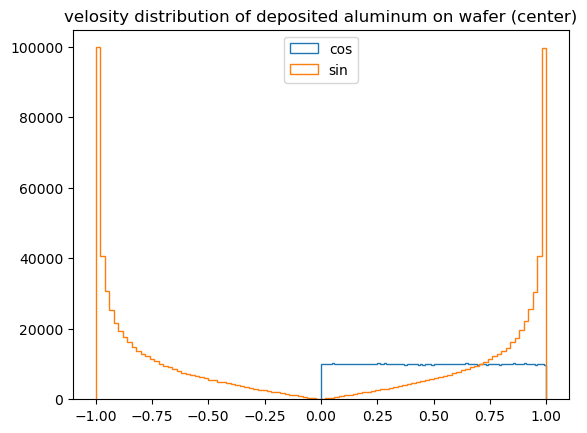

In [552]:
mu, sigma = 0, 0.1 # mean and standard deviation
# cos_chi = np.random.normal(mu, sigma, N)
cos_chi = np.random.rand(N)
sin_chi = np.sqrt(1-cos_chi**2)*np.random.choice([-1, 1], size=N)

fig, ax = plt.subplots()
ax.set_title("velosity distribution of deposited aluminum on wafer (center)")
ax.hist(cos_chi, bins=100,histtype='step', stacked=True, fill=False, label='cos')
ax.hist(sin_chi, bins=100,histtype='step', stacked=True, fill=False, label='sin')
# ax.set_yscale('log')
# ax.plot(X, hist_dist.cdf(X), label='CDF')
ax.legend()

In [553]:
ttestsm[1].shape

(1000000, 3)

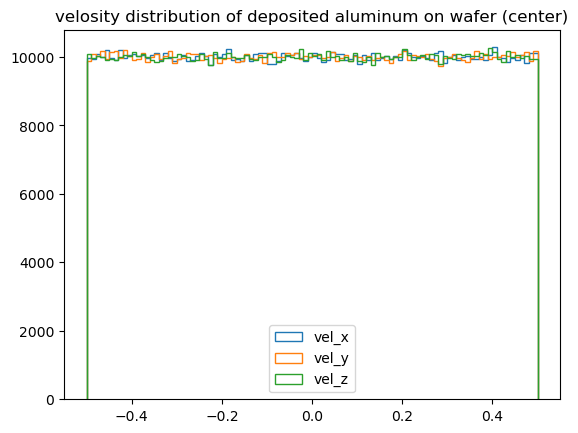

In [554]:
fig, ax = plt.subplots()
ax.set_title("velosity distribution of deposited aluminum on wafer (center)")
ax.hist(vtest[:,0], bins=100,histtype='step', stacked=True, fill=False, label='vel_x')
ax.hist(vtest[:,1], bins=100,histtype='step', stacked=True, fill=False, label='vel_y')
ax.hist(vtest[:,2], bins=100,histtype='step', stacked=True, fill=False, label='vel_z')
# ax.set_yscale('log')
# ax.plot(X, hist_dist.cdf(X), label='CDF')
ax.legend()

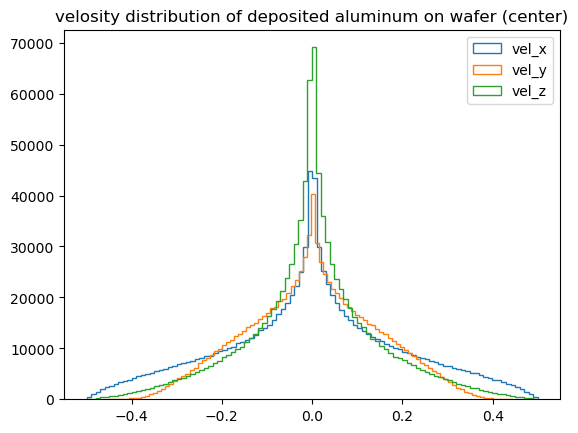

In [559]:
fig, ax = plt.subplots()
ax.set_title("velosity distribution of deposited aluminum on wafer (center)")
ax.hist(ttestsm[0][:,0], bins=100,histtype='step', stacked=True, fill=False, label='vel_x')
ax.hist(ttestsm[0][:,1], bins=100,histtype='step', stacked=True, fill=False, label='vel_y')
ax.hist(ttestsm[0][:,2], bins=100,histtype='step', stacked=True, fill=False, label='vel_z')
# ax.set_yscale('log')
# ax.plot(X, hist_dist.cdf(X), label='CDF')
ax.legend()

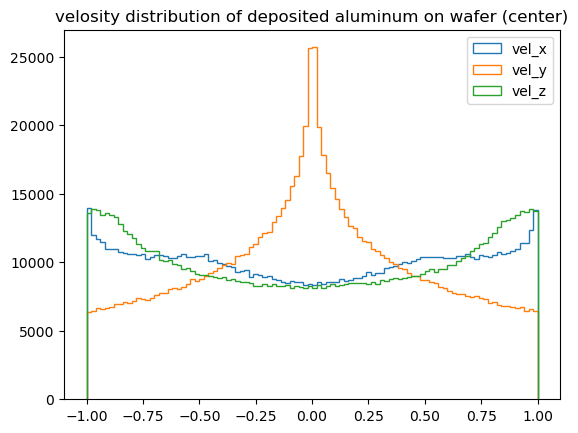

In [389]:
fig, ax = plt.subplots()
ax.set_title("velosity distribution of deposited aluminum on wafer (center)")
ax.hist(ttestsm[1][:,0], bins=100,histtype='step', stacked=True, fill=False, label='vel_x')
ax.hist(ttestsm[1][:,1], bins=100,histtype='step', stacked=True, fill=False, label='vel_y')
ax.hist(ttestsm[1][:,2], bins=100,histtype='step', stacked=True, fill=False, label='vel_z')
# ax.set_yscale('log')
# ax.plot(X, hist_dist.cdf(X), label='CDF')
ax.legend()

In [304]:
vtest = np.array([[0, 1e-17, 1], [0, 1e-11, 1]])
chi = np.array([np.pi/3, np.pi/3])
phi = np.array([1, 1])
# N = 10000000
# vtest = np.random.rand(N,3)
# chi = np.random.rand(N)*np.pi*2
# phi = np.random.rand(N)*np.pi*2
 
ttessci = newVel(vtest, np.linalg.norm(vtest, axis=1), chi, phi)
ttestsm = newVel_gpu(vtest, np.linalg.norm(vtest, axis=1), chi, phi)
print(np.allclose(ttessci, ttestsm))
print(ttessci)
print(ttestsm)

[[0.46791552 0.72873525 0.5       ]
 [0.46791552 0.72873525 0.5       ]]
dot
True
[[0.46791552 0.72873525 0.5       ]
 [0.46791552 0.72873525 0.5       ]]
[[0.46791552 0.72873525 0.5       ]
 [0.46791552 0.72873525 0.5       ]]


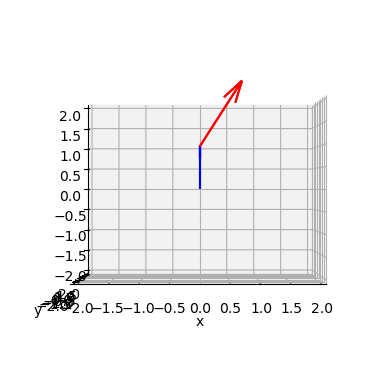

In [241]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
origin = np.zeros((2,3))
# Make the direction data for the arrows


ax.quiver(origin[:,0], origin[:,1], origin[:,2], vtest[:,0], vtest[:,1], vtest[:,2], color='blue')
ax.quiver(vtest[:,0], vtest[:,1], vtest[:,2], vtest[:,0]+ ttessci[:,0], vtest[:,1] + ttessci[:,1],vtest[:,2]+ ttessci[:,2], color='red')
# ax.quiver(origin[:,0], origin[:,1], origin[:,2], ttessci[:,0], ttessci[:,1], ttessci[:,2])
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.view_init(elev=0, azim=-90, roll=0)
plt.show()

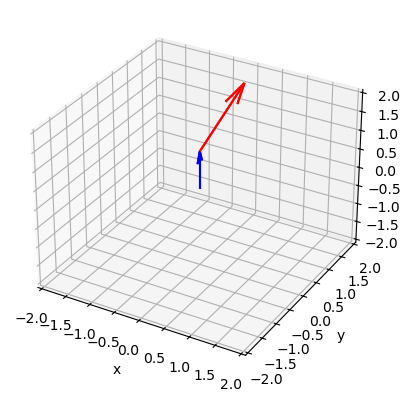

In [192]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
origin = np.zeros((2,3))
# Make the direction data for the arrows


ax.quiver(origin[:,0], origin[:,1], origin[:,2], vtest[:,0], vtest[:,1], vtest[:,2], color='blue')
ax.quiver(vtest[:,0], vtest[:,1], vtest[:,2], vtest[:,0]+ ttestsm[:,0], vtest[:,1] + ttestsm[:,1],vtest[:,2]+ ttestsm[:,2], color='red')
# ax.quiver(origin[:,0], origin[:,1], origin[:,2], ttessci[:,0], ttessci[:,1], ttessci[:,2])
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

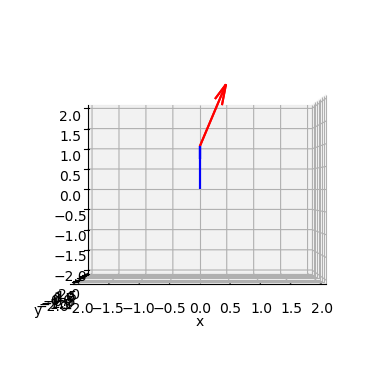

In [193]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
origin = np.zeros((2,3))
# Make the direction data for the arrows

ax.quiver(origin[:,0], origin[:,1], origin[:,2], vtest[:,0], vtest[:,1], vtest[:,2], color='blue')
ax.quiver(vtest[:,0], vtest[:,1], vtest[:,2], vtest[:,0]+ ttestsm[:,0], vtest[:,1] + ttestsm[:,1],vtest[:,2]+ ttestsm[:,2], color='red')
# ax.quiver(origin[:,0], origin[:,1], origin[:,2], ttessci[:,0], ttessci[:,1], ttessci[:,2])
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.view_init(elev=0, azim=-90, roll=0)

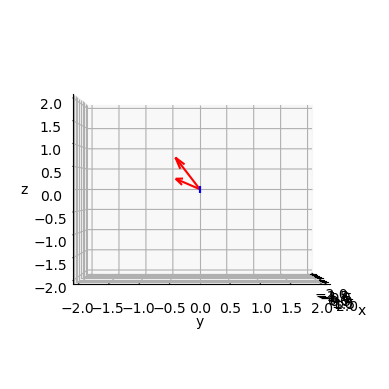

In [140]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
origin = np.zeros((2,3))
# Make the direction data for the arrows

ax.quiver(origin[:,0], origin[:,1], origin[:,2], ttestsm[:,0], ttestsm[:,1], ttestsm[:,2], color='red')
ax.quiver(origin[:,0], origin[:,1], origin[:,2], vtest[:,0], vtest[:,1], vtest[:,2], color='blue')
# ax.quiver(origin[:,0], origin[:,1], origin[:,2], ttessci[:,0], ttessci[:,1], ttessci[:,2])
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0, azim=0, roll=0)

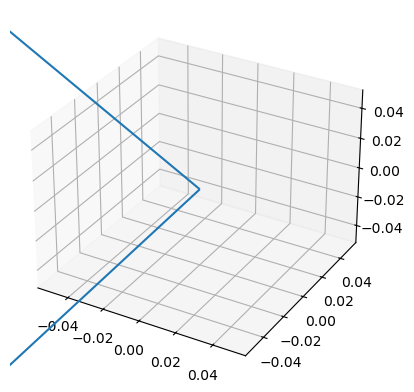

In [97]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
origin = np.zeros((2,3))
# Make the direction data for the arrows

ax.quiver(origin[:,0], origin[:,1], origin[:,2], ttestsm[:,0], ttestsm[:,1], ttestsm[:,2], length=1)
# ax.quiver(origin[:,0], origin[:,1], origin[:,2], ttessci[:,0], ttessci[:,1], ttessci[:,2])
plt.show()

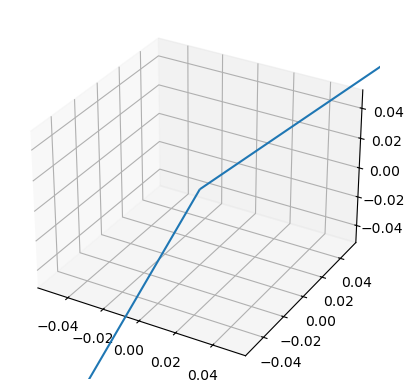

In [92]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
origin = np.zeros((2,3))
# Make the direction data for the arrows

ax.quiver(origin[:,0], origin[:,1], origin[:,2], ttessci[:,0], ttessci[:,1], ttessci[:,2])

plt.show()

In [76]:
print(ttessci)

[[1.22348146 0.17826223 3.07755028]
 [0.45357755 2.39721933 0.21819008]]


In [77]:
print(ttestsm)

[[ 1.80244213  0.74340111  2.6830127 ]
 [-1.51923571 -0.67482202  1.79903811]]


In [57]:
np.allclose(ttessci, ttestsm)

True

In [62]:
N = 1000000

vtest = np.random.rand(N, 3)
chi = np.random.rand(N)*np.pi
phi = np.random.rand(N)*np.pi
ttessci = newVel_gpu_sci(vtest, np.linalg.norm(vtest, axis=1), chi, phi)
ttestsm = newVel_gpu(vtest, np.linalg.norm(vtest, axis=1), chi, phi)
np.allclose(ttessci, ttestsm)

TypeError: newVel_gpu() takes 3 positional arguments but 4 were given

In [ ]:
vtest = np.array([[1, 1, 3], [2, 1, 1]])
chi = np.array([np.pi/3, np.pi/6])
phi = np.array([np.pi/3, np.pi/6])
ttessci = newVel_gpu_sci(vtest, np.linalg.norm(vtest, axis=1), chi, phi)
ttestsm = newVel_gpu(vtest, np.linalg.norm(vtest, axis=1), chi, phi)
np.allclose(ttessci, ttestsm)

[3.31662479 2.44948974]


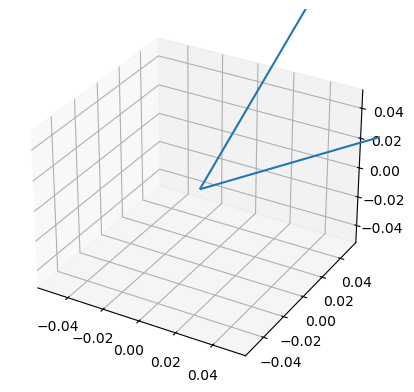

In [90]:
ax = plt.figure().add_subplot(projection='3d')

# Make the grid
origin = np.zeros((2,3))
vtest = np.array([[1, 1, 3], [2, 1, 1]])
vnorml = np.linalg.norm(vtest, axis=1)

print(vnorml)
# Make the direction data for the arrows

ax.quiver(origin[:,0], origin[:,1], origin[:,2], vtest[:,0]/vnorml, vtest[:,1]/vnorml, vtest[:,2]/vnorml)

plt.show()

In [294]:
N = 10000000
np.random.seed(10020)
chi = 2*np.pi*np.random.rand(N)
# chi = np.arccos(1-2*r/(1+8*(energy/27.21)*(1-r)))
phi = 2*np.pi*np.random.rand(N)
rotateAngle = np.array([np.sin(chi)*np.cos(phi), np.sin(chi)*np.sin(phi), np.cos(chi)])

In [295]:
rotateAngle.shape

(3, 10000000)

In [296]:
rotateAngle_min_1 = np.array(rotateAngle[0,:] > 0)
rotateAngle_min_1 = rotateAngle[0, rotateAngle_min_1]
print(rotateAngle_min_1.shape)
rotateAngle_plus_1 = np.array(rotateAngle[0,:] < 0)
rotateAngle_plus_1 = rotateAngle[0, rotateAngle_plus_1]
print(rotateAngle_plus_1.shape)

(4999613,)
(5000387,)


In [297]:
rotateAngle_min_1 = np.array(rotateAngle[1,:] > 0)
rotateAngle_min_1 = rotateAngle[0, rotateAngle_min_1]
print(rotateAngle_min_1.shape)
rotateAngle_plus_1 = np.array(rotateAngle[1,:] < 0)
rotateAngle_plus_1 = rotateAngle[0, rotateAngle_plus_1]
print(rotateAngle_plus_1.shape)

(5002173,)
(4997827,)


In [298]:
rotateAngle_min_1 = np.array(rotateAngle[2,:] > 0)
rotateAngle_min_1 = rotateAngle[0, rotateAngle_min_1]
print(rotateAngle_min_1.shape)
rotateAngle_plus_1 = np.array(rotateAngle[2,:] < 0)
rotateAngle_plus_1 = rotateAngle[0, rotateAngle_plus_1]
print(rotateAngle_plus_1.shape)

(5000506,)
(4999494,)


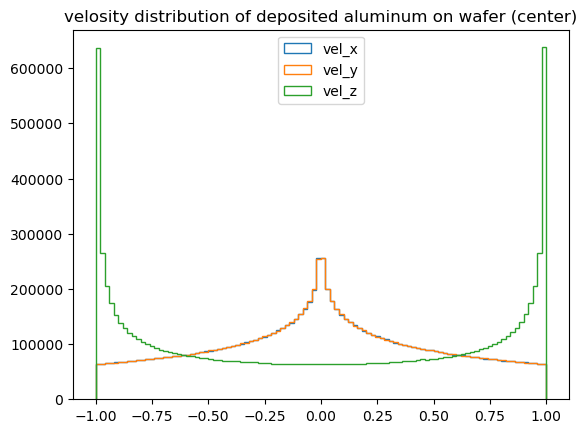

In [299]:
fig, ax = plt.subplots()
ax.set_title("velosity distribution of deposited aluminum on wafer (center)")
ax.hist(rotateAngle[0,:], bins=100,histtype='step', stacked=True, fill=False, label='vel_x')
ax.hist(rotateAngle[1,:], bins=100,histtype='step', stacked=True, fill=False, label='vel_y')
ax.hist(rotateAngle[2,:], bins=100,histtype='step', stacked=True, fill=False, label='vel_z')
# ax.set_yscale('log')
# ax.plot(X, hist_dist.cdf(X), label='CDF')
ax.legend()